Import použitých knižníc

In [77]:
# Tieto importy treba na final verziu zjednotit
import pandas as pd
import glob, os

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import mplfinance as fplt





In [123]:
files = glob.glob('InputData/*.csv')
df = pd.concat([pd.read_csv(fp, parse_dates=True).assign(Title=os.path.basename(fp).split('.')[0]) 
       for fp in files])

df['Date'] = pd.to_datetime(df['Date'])

# Create a new column 'is_last_day' to identify the last day of the month
df['IsLastDayOfMnth'] = df['Date'].dt.is_month_end

# set the index
df.set_index('Date', inplace=True)

df.rename(columns={'Adj Close':'AdjClose'}, inplace=True)

#print (df.head(2))
#print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
#print(df.info())

In [124]:
DistinctTitles=df['Title'].unique()

SelectTitle=widgets.ToggleButtons(
    options=DistinctTitles,
    description='Title:',
    disabled=False,
    button_style=''
)

def DistinctTitlePlot(SelectTitle):
    fplt.plot(  df[df['Title'] == SelectTitle],
            type='candle',
            style='charles',
            title=SelectTitle,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Shares\nTraded',
            warn_too_much_data=99999999
            )

   
out1 = widgets.interactive_output(DistinctTitlePlot, {'SelectTitle': SelectTitle})

display(SelectTitle)
display(out1)

ToggleButtons(description='Title:', options=('EEM', 'GLD', 'SPY', 'TLT', 'VGK'), value='EEM')

Output()

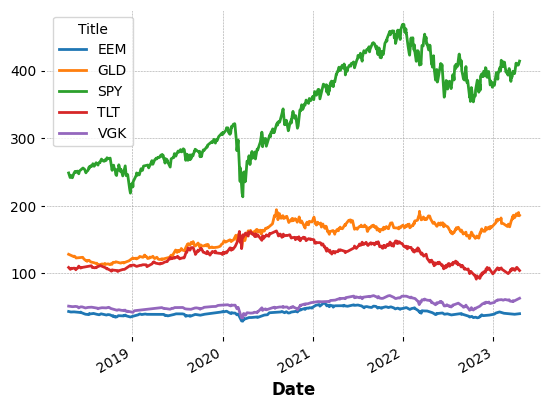

In [98]:
df.pivot(columns="Title", values="AdjClose").plot()

plt.show()

In [84]:
tmp = pd.Series([100, 110, 100, 200])
tmp.pct_change()

df.Close.pct_change()

Date
2018-04-18         NaN
2018-04-19   -0.005816
2018-04-20   -0.012537
2018-04-23   -0.008041
2018-04-24   -0.004693
                ...   
2023-04-11    0.003898
2023-04-12    0.007927
2023-04-13    0.013483
2023-04-14   -0.001584
2023-04-17   -0.004759
Name: Close, Length: 6290, dtype: float64

In [95]:
# Calculate daily returns. Calculate from CLOSE price (not form Adj. Close). Create separate column.
df['RDaily'] = df.Close / df.Open - 1


In [99]:
""" # Add separate columns for year, month, and day
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

# Group the DataFrame by 'Title', 'Year', and 'Month'
grouped_df = df.groupby(['Title', 'Year', 'Month'])

# Iterate through each group
for (title, year, month), group in grouped_df:
    # Perform operations """

""" 
#Percent change example
tmp = pd.Series([100, 110, 100, 200])
tmp.pct_change()

df.Close.pct_change() """

' \n#Percent change example\ntmp = pd.Series([100, 110, 100, 200])\ntmp.pct_change()\n\ndf.Close.pct_change() '

In [96]:
# SD of daily return for each title, year, month.
grouped_df = df.groupby(['Title', df.index.year, df.index.month])

for (title, year, month), group in grouped_df:
    print(grouped_df['RDaily'].std())

Title  Date  Date
EEM    2018  4       0.007247
             5       0.006033
             6       0.006776
             7       0.005185
             8       0.006344
                       ...   
VGK    2022  12      0.006625
       2023  1       0.007613
             2       0.006850
             3       0.008601
             4       0.003801
Name: RDaily, Length: 305, dtype: float64
Title  Date  Date
EEM    2018  4       0.007247
             5       0.006033
             6       0.006776
             7       0.005185
             8       0.006344
                       ...   
VGK    2022  12      0.006625
       2023  1       0.007613
             2       0.006850
             3       0.008601
             4       0.003801
Name: RDaily, Length: 305, dtype: float64
Title  Date  Date
EEM    2018  4       0.007247
             5       0.006033
             6       0.006776
             7       0.005185
             8       0.006344
                       ...   
VGK    2022  12      0